# Estimating Curvatures and Their Derivatives on Triangle Meshes

We reproduce here the curvature estimation algorithm described by [[Rusinkiewicz 2004]](#Rusinkiewicz2004).

In [49]:
import sys
sys.path.append('..')
import plot_stl

import igl
import numpy as np
from scipy.spatial.transform import Rotation
from typing import Tuple

eps = 1.0e-6

## Coordinate systems

This curvature algorithm deals with three types of coordinate systems: a global Cartesian frame, a per-face basis, and a per-vertex basis. The global Cartesian coordinate system is what we use to describe the coordinates (i.e. the placement) of each vertex. The per-face basis is a local coordinate system on each face of the triangle mesh, with the z-axis being the face normal. Similarly, the per-vertex basis is a local coordinate system on each vertex of the mesh, with the z-axis being the vertex normal.

We use the libigl local_basis function to calculate the per-face basis vectors.

For the per-vertex basis vectors, we calculate the vertex normal (the z-axis) as a weighted sum of the adjacent face normals [[Max 1999]](#Max1999) and then set "random" orthonormal vectors as the x- and y-axes. The exact orientations of the vertex x- and y-axes are not critical, so long as they form an orthonormal basis with the vertex normal.

In [50]:
# Create random normalized 3D vectors orthogonal to the input vectors
def random_orthonormal(vectors: np.array) -> np.array:
    rows, cols = vectors.shape
    if cols != 3:
        raise ValueError('Argument must be an M-by-3 numpy array.')

    magnitude = np.linalg.norm(vectors, ord=2, axis=1, keepdims=True)
    vec_norm = vectors / magnitude

    perturbation = 1.0
    perturb_vec = np.array(vec_norm)
    x_aligned = (1.0 - np.abs(vec_norm[:, 0])) < 1.0e-2
    perturb_vec[x_aligned, 1] += perturbation
    perturb_vec[np.logical_not(x_aligned), 0] += perturbation
    
    random_ortho_vector = np.cross(vectors, perturb_vec)
    magnitude = np.linalg.norm(random_ortho_vector, ord=2, axis=1, keepdims=True)
    random_ortho_vector /= magnitude
    return random_ortho_vector

def per_vertex_normals(vertices: np.array, faces: np.array):
    edge_squared = igl.edge_lengths(vertices, faces) ** 2
    normals = np.zeros(vertices.shape)
    for row in range(faces.shape[0]):
        for col in range(faces.shape[1]):
            i = (col - 1) % 3
            j = (col + 1) % 3
            edge_i = vertices[faces[row, j]] - vertices[faces[row, col]]
            edge_j = vertices[faces[row, i]] - vertices[faces[row, col]]
            normals[faces[row, col]] += np.cross(edge_i, edge_j) / (edge_squared[row, i] * edge_squared[row, j])
    for row in range(vertices.shape[0]):
        if (normals[row] == 0.0).all():
            normals[row] = np.nan
    return normals / np.linalg.norm(normals, ord=2, axis=1, keepdims=True)

def per_vertex_basis(vertex_normals: np.array) -> Tuple[np.array, np.array, np.array]:
    b2 = np.array(vertex_normals)
    b0 = random_orthonormal(b2)
    b1 = np.cross(b2, b0)

    return b0, b1, b2

## Sphere test

Let's calculate the curvature of a sphere. This is a nice test case to start with, since the curvature of a sphere is the inverse of the radius.

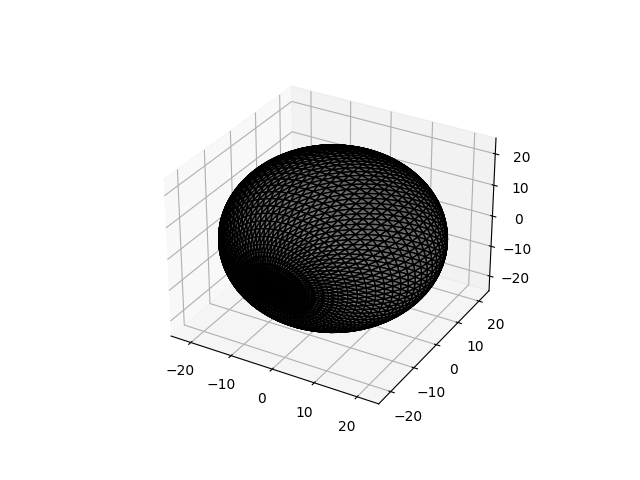

In [51]:
vertices, faces = igl.read_triangle_mesh('../../../data/meshes/sphere.stl')
vertices, faces = igl.remove_duplicates(vertices, faces, 1e-7)
for i in range(3):
	center = (vertices[:, i].max() - vertices[:, i].min()) / 2.0
	vertices[:, i] -= center
vertices /= np.linalg.norm(vertices, ord=2, axis=1, keepdims=True)
radius = 24.0
vertices *= radius

%matplotlib widget
plot_stl.plot_mesh(vertices, faces)

## Per-Face Curvature

**Definitions**
- $n$ is the face normal vector.<br>
- $u$ and $v$ (along with $n$) are the basis vectors of the local face coordinate system.<br>
- Triangle edge vectors are $e_{0}$, $e_{1}$, and $e_{2}$, where $e_{i}$ is opposite vertex $i$. The edge vectors are oriented according to the right-hand rule.
- Vertex normals are $n_{0}$, $n_{1}$, and $n_{2}$, where $n_{i}$ is located at vertex $i$.

The second fundamental tensor is defined by 

$$
\boldsymbol\Pi = \begin{bmatrix}
a & b \\
b & c
\end{bmatrix}
 = \begin{bmatrix}
\frac{\partial n}{\partial u} \cdot u & \frac{\partial n}{\partial v} \cdot u \\
\frac{\partial n}{\partial u} \cdot v & \frac{\partial n}{\partial v} \cdot v
\end{bmatrix}
$$

It is related to the directional derivative of the normal by 

$$
\boldsymbol\Pi \boldsymbol s = D_{s}n
$$

where $s$ is a vector in the tangent plane. If we combine these equations and approximate the derivatives with finite differences, we get

$$
\boldsymbol\Pi \begin{bmatrix}
e_{0} \cdot u \\
e_{0} \cdot v
\end{bmatrix}
= \begin{bmatrix}
(n_{2} - n_{1}) \cdot u \\
(n_{2} - n_{1}) \cdot v
\end{bmatrix}
$$

$$
\boldsymbol\Pi \begin{bmatrix}
e_{1} \cdot u \\
e_{1} \cdot v
\end{bmatrix}
= \begin{bmatrix}
(n_{0} - n_{2}) \cdot u \\
(n_{0} - n_{2}) \cdot v
\end{bmatrix}
$$

$$
\boldsymbol\Pi \begin{bmatrix}
e_{2} \cdot u \\
e_{2} \cdot v
\end{bmatrix}
= \begin{bmatrix}
(n_{1} - n_{0}) \cdot u \\
(n_{1} - n_{0}) \cdot v
\end{bmatrix}
$$

Expanding everything out, we get 

$$
\begin{bmatrix}
e_{0} \cdot u & e_{0} \cdot v & 0             \\
0             & e_{0} \cdot u & e_{0} \cdot v \\
e_{1} \cdot u & e_{1} \cdot v & 0             \\
0             & e_{1} \cdot u & e_{1} \cdot v \\
e_{2} \cdot u & e_{2} \cdot v & 0             \\
0             & e_{2} \cdot u & e_{2} \cdot v 
\end{bmatrix}
\begin{bmatrix}
a\\
b\\
c
\end{bmatrix}
= \begin{bmatrix}
(n_{2} - n_{1}) \cdot u \\
(n_{2} - n_{1}) \cdot v \\
(n_{0} - n_{2}) \cdot u \\
(n_{0} - n_{2}) \cdot v \\
(n_{1} - n_{0}) \cdot u \\
(n_{1} - n_{0}) \cdot v 
\end{bmatrix}
$$

We can then use least squares to solve this system of equations for the elements of the second fundamental tensor ($a$, $b$, $c$).

In [52]:
vertex_normals = per_vertex_normals(vertices, faces)
vert_basis0, vert_basis1, vert_basis2 = per_vertex_basis(vertex_normals)
face_basis0, face_basis1, face_basis2 = igl.local_basis(vertices, faces)

# Edge vectors are #faces-by-3
edge0 = vertices[faces[:, 2]] - vertices[faces[:, 1]]
edge1 = vertices[faces[:, 0]] - vertices[faces[:, 2]]
edge2 = vertices[faces[:, 1]] - vertices[faces[:, 0]]

e0_b0 = np.einsum('ij,ij->i', edge0, face_basis0)
e0_b1 = np.einsum('ij,ij->i', edge0, face_basis1)
e1_b0 = np.einsum('ij,ij->i', edge1, face_basis0)
e1_b1 = np.einsum('ij,ij->i', edge1, face_basis1)
e2_b0 = np.einsum('ij,ij->i', edge2, face_basis0)
e2_b1 = np.einsum('ij,ij->i', edge2, face_basis1)

normal0 = vertex_normals[faces[:, 0]]
normal1 = vertex_normals[faces[:, 1]]
normal2 = vertex_normals[faces[:, 2]]

# [a, b, c] where the second fundamental form is [[a, b],
#                                                 [b, c]]
second_fundamental_fb = np.empty(faces.shape)
for ii in range(faces.shape[0]):
    # Solve for the second fundamental form using least squares
    coeffs = np.array([[e0_b0[ii], e0_b1[ii], 0.0      ],
                       [0.0,       e0_b0[ii], e0_b1[ii]],
                       [e1_b0[ii], e1_b1[ii], 0.0      ],
                       [0.0,       e1_b0[ii], e1_b1[ii]],
                       [e2_b0[ii], e2_b1[ii], 0.0      ],
                       [0.0,       e2_b0[ii], e2_b1[ii]]])
    dep_var = np.array([[np.dot(normal2[ii] - normal1[ii], face_basis0[ii])],
                        [np.dot(normal2[ii] - normal1[ii], face_basis1[ii])],
                        [np.dot(normal0[ii] - normal2[ii], face_basis0[ii])],
                        [np.dot(normal0[ii] - normal2[ii], face_basis1[ii])],
                        [np.dot(normal1[ii] - normal0[ii], face_basis0[ii])],
                        [np.dot(normal1[ii] - normal0[ii], face_basis1[ii])]])

    x, _, _, _ = np.linalg.lstsq(coeffs, dep_var, rcond=None)
    second_fundamental_fb[ii] = x.transpose()

## Per-Vertex Curvature

Much like calculating vertex normals from the surrounding face normals, the vertex curvatures are calculated by a weighted sum of the surrounding face curvatures. The weights chosen for this algorithm are the Voronoi areas [[Meyer 2003]](#Meyer2003).

In [53]:
def voronoi_area(vertices: np.array, faces: np.array):
    area = igl.doublearea(vertices, faces) / 2.0
    angles = igl.internal_angles(vertices, faces)
    half_cot = igl.cotmatrix_entries(vertices, faces)
    edge_squared = igl.edge_lengths(vertices, faces) ** 2
    nonobtuse = np.all(angles <= np.pi / 2.0, axis=1)

    v_area = np.empty(faces.shape)
    for row in range(faces.shape[0]):
        for col in range(faces.shape[1]):
            if nonobtuse[row]:
                i = (col - 1) % 3
                j = (col + 1) % 3
                v_area[row, col] = 0.25 * (edge_squared[row, i] * half_cot[row, i] 
                                           + edge_squared[row, j] * half_cot[row, j])
            else:
                if angles[row, col] > np.pi / 2.0:
                    v_area[row, col] = area[row] / 2.0
                else:
                    v_area[row, col] = area[row] / 4.0

    return v_area

Before summing the face curvatures, though, the various face coordinate systems must be aligned. We simply rotate each face coordinate system around the cross product of the face normal and the vertex normal. I don't really understand how we can just rotate a coordinate system without screwing things up, but it gives us the right answer, so ¯\\\_(ツ)\_/¯. Once the coordinate systems are coplanar, we can project the face basis onto the vertex basis to get the components of the second fundamental tensor in the vertex frame.

Here's the math:

$$
a_{v} = \begin{bmatrix}
u_{v} \cdot u_{f} \\
u_{v} \cdot v_{f}
\end{bmatrix}
\boldsymbol\Pi
\begin{bmatrix}
u_{v} \cdot u_{f} \\
u_{v} \cdot v_{f}
\end{bmatrix}
$$

$$
b_{v} = \begin{bmatrix}
u_{v} \cdot u_{f} \\
u_{v} \cdot v_{f}
\end{bmatrix}
\boldsymbol\Pi
\begin{bmatrix}
v_{v} \cdot u_{f} \\
v_{v} \cdot v_{f}
\end{bmatrix}
$$

$$
c_{v} = \begin{bmatrix}
v_{v} \cdot u_{f} \\
v_{v} \cdot v_{f}
\end{bmatrix}
\boldsymbol\Pi
\begin{bmatrix}
v_{v} \cdot u_{f} \\
v_{v} \cdot v_{f}
\end{bmatrix}
$$

where the $v$ subscript denotes vertex coordinates, and $f$ denotes face coordinates. Expanding this out, we get

$$
a_{v} = a_{f}(u_{v} \cdot u_{f})^{2} + 2b(u_{v} \cdot u_{f})(u_{v} \cdot v_{f}) + c(u_{v} \cdot v_{f})^2
$$

$$
b_{v} = a_{f}(u_{v} \cdot u_{f})(v_{v} \cdot u_{f}) + b(u_{v} \cdot u_{f})(v_{v} \cdot v_{f}) + b(u_{v} \cdot v_{f})(v_{v} \cdot u_{f}) + c(u_{v} \cdot v_{f})(v_{v} \cdot v_{f})
$$

$$
c_{v} = a_{f}(v_{v} \cdot u_{f})^{2} + 2b(v_{v} \cdot u_{f})(v_{v} \cdot v_{f}) + c(v_{v} \cdot v_{f})^2
$$

Now that we have transformed the per-face second fundamental tensor components to the vertex frame, we can perform the weighted sum to get the per-vertex second fundamental tensors.

In [54]:
weights = voronoi_area(vertices, faces)
sum_weights = np.zeros((vertices.shape[0], 1))
second_fundamental_vb = np.zeros(vertices.shape)
for row in range(faces.shape[0]):
    for col in range(faces.shape[1]):
        v_idx = faces[row, col]
        # Rotate the basis vectors about the cross-product of the face and vertex normals
        angle = np.arccos(np.dot(face_basis2[row], vert_basis2[v_idx]))
        if angle < eps:
            rot_vec = np.zeros((1, 3))
        else:
            rot_vec = np.cross(face_basis2[row], vert_basis2[v_idx])
            magnitude = np.linalg.norm(rot_vec, ord=2)
            rot_vec /= magnitude
            rot_vec *= angle
        r = Rotation.from_rotvec(rot_vec)
        face_basis0_vb = r.apply(face_basis0[row])
        face_basis1_vb = r.apply(face_basis1[row])
        
        vb0_fb0 = np.dot(vert_basis0[v_idx], face_basis0_vb)
        vb0_fb1 = np.dot(vert_basis0[v_idx], face_basis1_vb)
        vb1_fb0 = np.dot(vert_basis1[v_idx], face_basis0_vb)
        vb1_fb1 = np.dot(vert_basis1[v_idx], face_basis1_vb)

        a = (second_fundamental_fb[row, 0] * vb0_fb0 * vb0_fb0) \
            + (2.0 * second_fundamental_fb[row, 1] * vb0_fb0 * vb0_fb1) \
            + (second_fundamental_fb[row, 2] * vb0_fb1 * vb0_fb1)
        b = (second_fundamental_fb[row, 0] * vb0_fb0 * vb1_fb0) \
            + (second_fundamental_fb[row, 1] * vb0_fb0 * vb1_fb1) \
            + (second_fundamental_fb[row, 1] * vb0_fb1 * vb1_fb0) \
            + (second_fundamental_fb[row, 2] * vb0_fb1 * vb1_fb1)
        c = (second_fundamental_fb[row, 0] * vb1_fb0 * vb1_fb0) \
            + (2.0 * second_fundamental_fb[row, 1] * vb1_fb0 * vb1_fb1) \
            + (second_fundamental_fb[row, 2] * vb1_fb1 * vb1_fb1)
        
        weight = weights[row, col]
        second_fundamental_vb[v_idx, 0] += weight * a
        second_fundamental_vb[v_idx, 1] += weight * b
        second_fundamental_vb[v_idx, 2] += weight * c
        sum_weights[v_idx] += weight

second_fundamental_vb /= sum_weights

## Curvature from the second fundamental tensor

Principal curvatures (minimum and maximum curvature) and directions are the eigenvalues and eigenvectors of the second fundamental tensor.

In [57]:
principal_curvature = np.empty((vertices.shape[0], 2))
for row in range(vertices.shape[0]):
    a = second_fundamental_vb[row, 0]
    b = second_fundamental_vb[row, 1]
    c = second_fundamental_vb[row, 2]
    principal_curvature[row] = np.linalg.eigvalsh(np.array([[a, b], [b, c]]))

In [60]:
tolerance = 1.0e-6
if np.all(np.abs((principal_curvature - (1.0 / radius))) < tolerance):
    print('Sphere curvature is', 1.0 / radius)
else:
    print('ERROR!')
    print(principal_curvature)

Sphere curvature is 0.041666666666666664


## References

<a id="Max1999">[Max 1999]</a> 
Max, N. (1999). Weights for Computing Vertex Normals from Facet Normals. Journal of Graphics Tools, 4(2), 1–6. https://doi.org/10.1080/10867651.1999.10487501

<a id="Meyer2003">[Meyer 2003]</a>
Meyer, M., Desbrun, M., Schröder, P., & Barr, A. H. (2003). Discrete Differential-Geometry Operators for Triangulated 2-Manifolds (pp. 35–57). https://doi.org/10.1007/978-3-662-05105-4_2

<a id="Rusinkiewicz2004">[Rusinkiewicz 2004]</a>
Rusinkiewicz, S. Estimating curvatures and their derivatives on triangle meshes. Proceedings. 2nd International Symposium on 3D Data Processing, Visualization and Transmission, 2004. 3DPVT 2004., 486–493. https://doi.org/10.1109/TDPVT.2004.1335277